In [9]:
import pandas as pd
import numpy as np
import gym
import torch
import random

from torch.utils.tensorboard import SummaryWriter
from importlib import reload
import sys

from scipy.stats import poisson, beta, norm
import matplotlib.pyplot as plt
import seaborn as sns
from sympy import *

sns.set_style("dark")

In [10]:
%load_ext tensorboard

In [11]:
#jt -t oceans16

In [18]:
%tensorboard --logdir logs

### Plan

Experiments on MountainCar, CartPole, and AcroBot (env with discrete action spaces) using small DQN-QR network
- Methods: DQN-QR (baseline), Parallel DQN-QR, Parallel DQN-QR with Biased Risk Profile (DDQN-QR-B), DDQN-QR-B with normalizing bias
- Implement n-step returns and compare performance

1. Experiment 1: Performance and learning on 5k time steps repeated 10 times for each method
    - Plot avg learning curve with 50% std deviation
    - Evaluation performance box plot 
2. Experiment 2: Priority replay experiments on 5k time steps repeated 10 times for each method. Test for best method from prior experiment
    - Hypothesized ideal formulation: resource allocation based on softmax over UCB. Then priority sampling 
    - Compare Uniform, Priority, Thread-Based Priority, Thread-Based Priority with Exploration Bonus
    - Learning curves wi 50% std deviation

### Test and Improve Baselines|

In [13]:
def get_df(results):
    stats = ['Average Reward', '% Optimal Action']
    df = pd.DataFrame(results, index = stats)

    df = df.explode(column=list(df.columns))
    df.index = [df.index, df.groupby(df.index).cumcount()]

    return df

In [14]:
import dqn_qr, utils.memory

reload(utils)
reload(dqn_qr)

from dqn_qr import train_qr, train_nstep_qr, evaluate, QrNetwork
from utils.memory import ReplayMemory, ParallelReplayMemory, TPReplayMemory

mps
mps


In [15]:
def train_on_control_task(N, alpha, risk_distortion, num_episodes, eval_every, eps_function, run_name, capacity=10000):
    writer = SummaryWriter("logs/" + run_name)
    
    qr = QrNetwork(state_dims=env.observation_space.shape[0], num_actions=env.action_space.n, n=N, alpha=alpha)
    qr_target = QrNetwork(state_dims=env.observation_space.shape[0], num_actions=env.action_space.n, n=N, alpha=alpha)

    replay = ReplayMemory(capacity=capacity)
    qr, G = train_nstep_qr(env, qr, qr_target, gamma=1., num_episodes=num_episodes, batch_size=64, eval_every=50, eps=eps,
                           n_step=1, memory=replay, soft=False)    

In [17]:
%%time

#test sequential DQN-QR
env_name = 'MountainCar-v0'
env = gym.make(env_name)

N = 16
alpha = 1e-3
num_episodes = 500
replay = ReplayMemory(capacity=10000)
writer = SummaryWriter("logs/" + "test_two")

eps_start, eps_end, eps_dec = 0.9, 0.05, 500
eps = lambda steps: eps_end + (eps_start - eps_end) * np.exp(-1. * steps / eps_dec)

qr = QrNetwork(state_dims=env.observation_space.shape[0], num_actions=env.action_space.n, n=N, alpha=alpha)
qr_target = QrNetwork(state_dims=env.observation_space.shape[0], num_actions=env.action_space.n, n=N, alpha=alpha)

qr, G = train_nstep_qr(env, qr, qr_target, writer, gamma=1., num_episodes=num_episodes, batch_size=64, eval_every=50, eps=eps,
                       n_step=1, memory=replay, soft=False)

Eval Return Episode 0: -200.0 | Actual Return Episode 0 -200.0
Eval Return Episode 50: -200.0 | Actual Return Episode 50 -199.39
Eval Return Episode 100: -200.0 | Actual Return Episode 100 -198.78
Eval Return Episode 150: -200.0 | Actual Return Episode 150 -199.19
Eval Return Episode 200: -200.0 | Actual Return Episode 200 -198.68
Eval Return Episode 250: -200.0 | Actual Return Episode 250 -197.96
Eval Return Episode 300: -121.33 | Actual Return Episode 300 -191.43
Eval Return Episode 350: -151.67 | Actual Return Episode 350 -187.71
Eval Return Episode 400: -200.0 | Actual Return Episode 400 -185.25
Eval Return Episode 450: -190.33 | Actual Return Episode 450 -186.74
CPU times: user 1min 39s, sys: 20.9 s, total: 2min
Wall time: 1min 44s


In [26]:
r = evaluate(env, qr, 1, 100)
r.describe()

count    100.000000
mean    -103.290000
std        4.176159
min     -105.000000
25%     -105.000000
50%     -105.000000
75%     -103.000000
max      -84.000000
dtype: float64

In [83]:
%%time

#test sequential DQN-QR
env_name = 'CartPole-v1'
env = gym.make(env_name)

N = 16
alpha = 5e-4
num_episodes = 1000
replay = ReplayMemory(capacity=1000)

eps_start, eps_end, eps_dec = 0.9, 0.01, 10000
eps = lambda steps: eps_end + (eps_start - eps_end) * np.exp(-1. * steps / eps_dec)
#eps = lambda steps: .05

qr_cartpole = QrNetwork(state_dims=env.observation_space.shape[0], num_actions=env.action_space.n, n=N, alpha=alpha)
qr_target_cartpole = QrNetwork(state_dims=env.observation_space.shape[0], num_actions=env.action_space.n, n=N, alpha=alpha)

qr_cartpole, G = train_nstep_qr(env, qr_cartpole, qr_target_cartpole, gamma=1., num_episodes=50000, 
                                batch_size=64, eps=eps, eval_every=1000, n_step = 1)

Eval Return Episode 0: 9.56 | Actual Return Episode 0 27.0
Eval Return Episode 1000: 9.26 | Actual Return Episode 1000 13.69


KeyboardInterrupt: 

In [19]:
num_processes = 5

eps = .1
params = {'state_dims': env.observation_space.shape[0], 'num_actions': env.action_space.n, 'n': N, 'alpha': alpha, 'decay': 0}
training_params = {'env': env, 'gamma': 1., 'iterations':20000, 'batch_size':128, 'epsilon':eps, 'num_processes':num_processes, 'refresh_rate':50}    

In [ ]:
#test biased DDQN-QR
qr_input = Biased_QR_Network(**params)
p_replay = ParallelReplayMemory(20000, num_processes)
tp_replay = TPReplayMemory(20000, num_processes)
    
#tp_replay = ParallelReplayMemory(10000, num_processes)
training_params['filename'] = 'model_scripted.pt'
training_params['decay_rates'] = np.array([-.2, -.1, .0, .1, .2])
training_params['qr'] = qr_input
training_params['memory_type'] = ParallelReplayMemory
training_params['memory_size'] = 20000
qr_output = train_parallel_qr(**training_params)

### Motivating Examples
Test out the combination of optimistic and risk aware RL. 

#### Simple Risk-Averse Formulations

First experiment is training on environments with a neutral policy and evaluating with a risk-averse formulation 

In [23]:
def get_exp_weights(rate, n):
    t = Symbol('t')
    if rate == 0: return np.full(n, 1./n)
    y = rate * pow(np.e, -rate * t)

    f = lambdify(t, y, 'numpy')
    w = np.ones(n).cumsum()
    return f(w)/f(w).sum()

In [33]:
n = 16
q = np.full(n, 1./n).cumsum() - np.full(n, 1./(n * 2))

weights, decay_rates = [], np.linspace(-.5, .5, num=10).round(2)
for r in decay_rates:
    w = get_exp_weights(rate = r , n = n)
    weights.append(w)

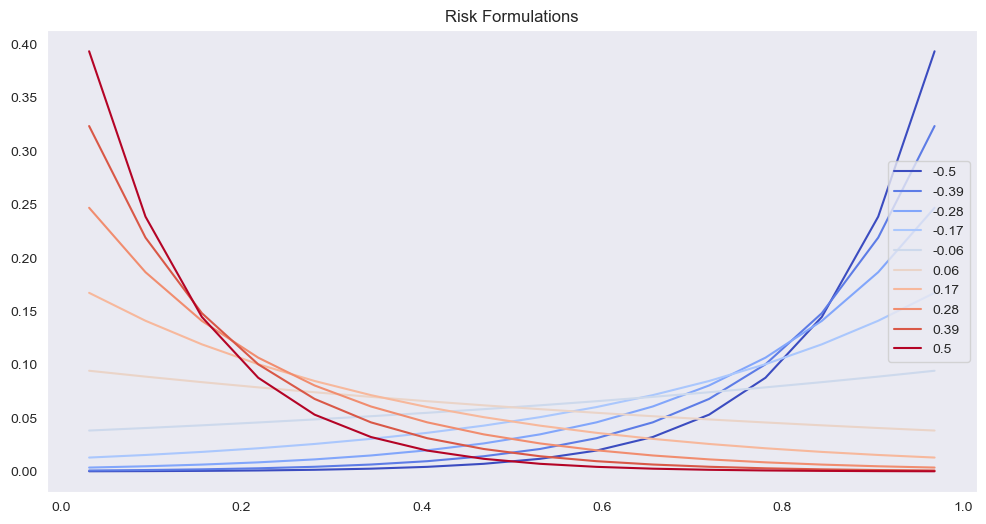

In [34]:
pd_w = pd.DataFrame(data = np.array(weights).T, columns = decay_rates, index = q)
pd_w.plot(title = 'Risk Formulations', figsize = (12, 6), colormap = 'coolwarm').legend(loc='right')

In [54]:
%%time

returns = pd.DataFrame()
for w, r in zip(weights, decay_rates):
    g = evaluate(env, qr, gamma=1, num_episodes=500, w = torch.Tensor(w))
    returns[r] = g

CPU times: user 31.5 s, sys: 16.6 ms, total: 31.5 s
Wall time: 31.6 s


In [58]:
returns

,-0.50,-0.39,-0.28,-0.17,-0.06,0.06,0.17,0.28,0.39,0.50
0,-154.0,-92.0,-150.0,-153.0,-98.0,-158.0,-113.0,-200.0,-200.0,-200.0
1,-153.0,-153.0,-152.0,-93.0,-157.0,-153.0,-153.0,-200.0,-200.0,-200.0
2,-94.0,-150.0,-94.0,-91.0,-93.0,-154.0,-153.0,-200.0,-200.0,-200.0
3,-150.0,-151.0,-150.0,-90.0,-151.0,-152.0,-111.0,-200.0,-200.0,-200.0
4,-161.0,-152.0,-150.0,-92.0,-154.0,-152.0,-110.0,-200.0,-200.0,-200.0
...,...,...,...,...,...,...,...,...,...,...
495,-151.0,-152.0,-91.0,-152.0,-155.0,-90.0,-111.0,-200.0,-200.0,-200.0
496,-93.0,-151.0,-161.0,-152.0,-96.0,-151.0,-153.0,-200.0,-200.0,-200.0
497,-150.0,-155.0,-93.0,-152.0,-155.0,-154.0,-112.0,-200.0,-200.0,-200.0
498,-92.0,-92.0,-153.0,-91.0,-154.0,-154.0,-111.0,-200.0,-200.0,-200.0


<Axes: title={'center': 'Performance of Various RIsk Measures on Mountain-Car Task'}>

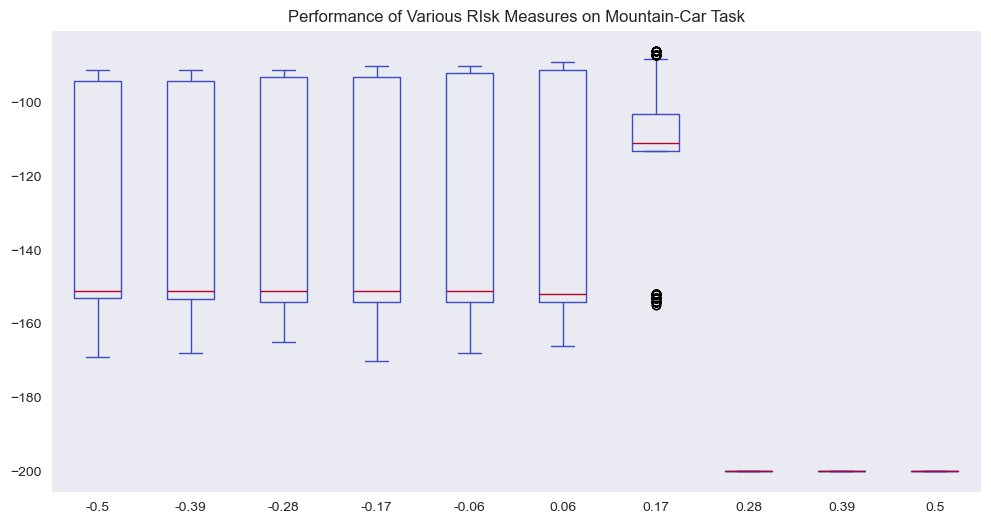

In [64]:
returns.plot.box(title = 'Performance of Various Risk Measures on Mountain-Car Task', figsize = (12, 6), colormap = 'coolwarm')

In [56]:
threads = list(range(4))
a = dict((t, 1) for t in threads)
a

{0: 1, 1: 1, 2: 1, 3: 1}

In [ ]:
for param_in, param_out in zip(qr_input.parameters(), qr_output.parameters()):
  print('input', param_in.data)
  print('output', param_out.data)

### Baselines

In [7]:
import gymnasium as gym
import numpy as np

from stable_baselines3 import TD3
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

env = gym.make("Pendulum-v1", render_mode="rgb_array")

# The noise objects for TD3
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

model = TD3("MlpPolicy", env, action_noise=action_noise, verbose=1)
model.learn(total_timesteps=10000, log_interval=10)
model.save("td3_pendulum")
vec_env = model.get_env()

del model # remove to demonstrate saving and loading

model = TD3.load("td3_pendulum")

obs = vec_env.reset()
while True:
    action, _states = model.predict(obs)
    obs, rewards, dones, info = vec_env.step(action)
    vec_env.render("human")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


KeyboardInterrupt: 

In [8]:
!conda install stable_baselines

Channels:
 - defaults
 - conda-forge
Platform: osx-arm64
Solving environment: failed

PackagesNotFoundError: The following packages are not available from current channels:

  - stable_baselines

Current channels:

  - defaults
  - https://conda.anaconda.org/conda-forge/noarch
  - https://conda.anaconda.org/conda-forge/osx-arm64

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




In [9]:
!conda install conda-forge::stable-baselines3

Channels:
 - defaults
 - conda-forge
Platform: osx-arm64
Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3

  added / updated specs:
    - conda-forge::stable-baselines3


The following packages will be SUPERSEDED by a higher-priority channel:

  certifi            conda-forge/noarch::certifi-2024.2.2-~ --> pkgs/main/osx-arm64::certifi-2024.2.2-py311hca03da5_0 


Proceed ([y]/n)? ^C

CondaSystemExit: 
Operation aborted.  Exiting.

